## Modelling and Evaluation Notebook

---

## Objectives

* Business requirement 2 ;

   * Set and create the necessary model features.

   * Classify and differentiate the data between healthy and infected with powdery mildew cherry leaves.

## Inputs

* inputs/cherry_leaves_dataset/train
* inputs/cherry_leaves_dataset/test
* inputs/cherry_leaves_dataset/validate
* Embeddings of the image shapes. 

## Outputs

* Images distribution plot in train, validation, and test set
* Image augmentation
* Class indices to change prediction inference in labels
* Machine learning model creation and training
* Save model
* Learning curve plot for model performance
* Model evaluation on pickle file
* Prediction on the random image file




---

## Change and set the directory

##### Import Packages 

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.image import imread

The directory needs to be set from current to parent directory

In [2]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves/jupyter_notebooks'

In [3]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


In [4]:
current_dir = os.getcwd()
current_dir

'/workspace/mildew-detection-in-cherry-leaves'

##### Set input Directories

In [5]:
my_data_dir = 'inputs/cherry_leaves_dataset/cherry-leaves'
train_path = my_data_dir + '/train'
val_path = my_data_dir + '/validation'
test_path = my_data_dir + '/test'

##### Set output Directories

In [6]:
version = 'v1'

file_path = f'outputs/{version}'
version_file_path = os.path.join(current_dir, file_path)

if os.path.exists(version_file_path):
    print(f"version {version} already exists. Create a new version")
    pass
else:
    os.makedirs(name=file_path)

version v1 already exists. Create a new version


##### Set labels

In [7]:
labels = os.listdir(train_path)

print(
    f"Project Labels: {labels}"
    )

Project Labels: ['healthy', 'powdery_mildew']


##### Set image shape

In [8]:
## Import saved image shape embedding
import joblib
version = 'v1'
image_shape = joblib.load(filename=f"outputs/{version}/image_shape.pkl")
image_shape

(256, 256, 3)

---

### The amount of images in train, test and validate data

* train - healthy: 1472 images
* train - powdery_mildew: 1472 images
* validation - healthy: 210 images
* validation - powdery_mildew: 210 images
* test - healthy: 422 images
* test - powdery_mildew: 422 images




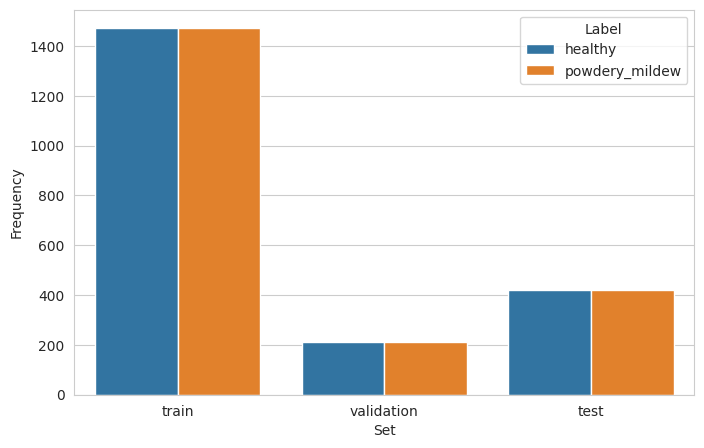

In [9]:
df_freq = pd.DataFrame([]) 
for folder in ['train', 'validation', 'test']:
  for label in labels:
    df_freq = df_freq.append(
        pd.Series(data={'Set': folder,
                        'Label': label,
                        'Frequency':int(len(os.listdir(my_data_dir+'/'+ folder + '/' + label)))}
                  ),
                  ignore_index=True
        )
    
    print(f"* {folder} - {label}: {len(os.listdir(my_data_dir+'/'+ folder + '/' + label))} images")

print("\n")
sns.set_style("whitegrid")
plt.figure(figsize=(8,5))
sns.barplot(data=df_freq, x='Set', y='Frequency', hue='Label')
plt.savefig(f'{file_path}/labels_distribution.png', bbox_inches='tight', dpi=150)
plt.show()

### Image data augmentation

The train set contains 1472 images in both categories (healthy and infected sample leaf images).This is not suffiient for a deep nueral network learning model. The dataset size must be increased with image augmentation.

Parameters

In [10]:
batch_size = 32
data_color_mode = 'rgb'
data_class_mode = 'binary'

Import the "Data Image Generator"

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

2023-02-12 11:45:05.428412: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-12 11:45:05.540763: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-12 11:45:05.540787: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-12 11:45:06.294466: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

Initialize the "Data Image Generator"

In [12]:
augmented_image_data = ImageDataGenerator(rotation_range=20,
                                   width_shift_range=0.10, 
                                   height_shift_range=0.10,
                                   shear_range=0.1,
                                   zoom_range=0.1,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                   fill_mode='nearest',
                                   rescale=1./255
                              )

Augment training dataset images

In [13]:
batch_size = 20 # Set batch size
train_set = augmented_image_data.flow_from_directory(train_path,
                                              target_size=image_shape[:2],
                                              color_mode='rgb',
                                              batch_size=batch_size,
                                              class_mode='binary',
                                              shuffle=True
                                              )

train_set.class_indices

Found 2944 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment validation dataset images

In [14]:
validation_set = ImageDataGenerator(rescale=1./255).flow_from_directory(val_path,
                                                          target_size=image_shape[:2],
                                                          color_mode='rgb',
                                                          batch_size=batch_size,
                                                          class_mode='binary',
                                                          shuffle=False
                                                          )

validation_set.class_indices

Found 420 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Augment test dataset images

In [15]:
test_set = ImageDataGenerator(rescale=1./255).flow_from_directory(test_path,
                                                    target_size=image_shape[:2],
                                                    color_mode='rgb',
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False
                                                    )

test_set.class_indices

Found 844 images belonging to 2 classes.


{'healthy': 0, 'powdery_mildew': 1}

Plot augmented training image

In [16]:
def plot_augmented_image(label_set, display_size=3):
    label_class = label_set.class_indices
    for _ in range(display_size):
        img, label = label_set.next()
        print(img.shape)
        img_class = list(label_class.keys())[
            list(label_class.values()).index(label[0])]
        plt.imshow(img[0])
        plt.axis('off')
        plt.title(img_class)
        plt.show()

Training image set

(20, 256, 256, 3)


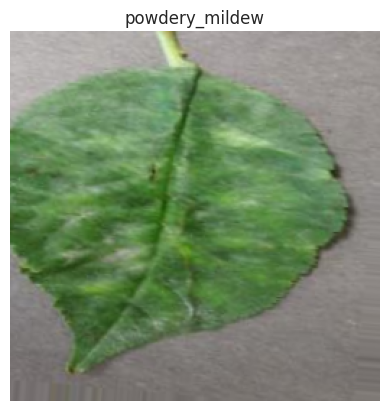

(20, 256, 256, 3)


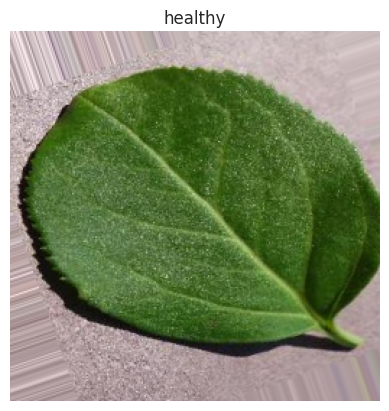

(20, 256, 256, 3)


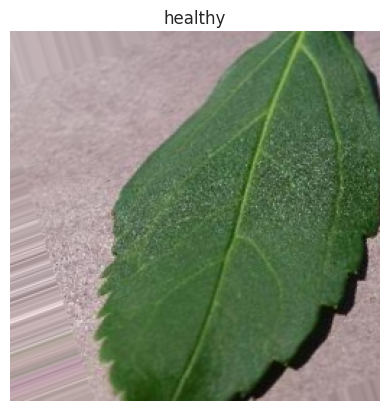

In [17]:
plot_augmented_image(train_set)

Validation image set

(20, 256, 256, 3)


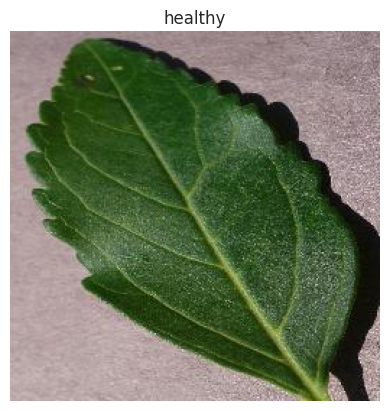

(20, 256, 256, 3)


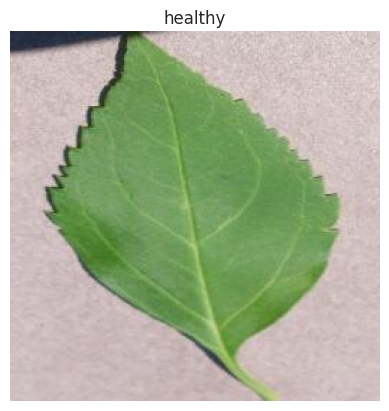

(20, 256, 256, 3)


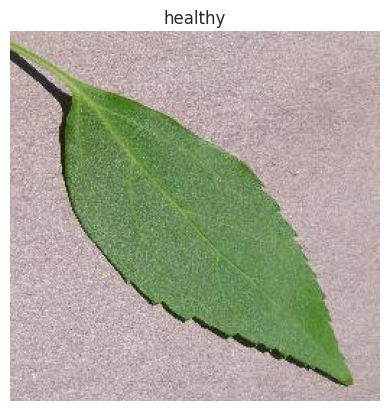

In [18]:
plot_augmented_image(validation_set)

Test image set

(20, 256, 256, 3)


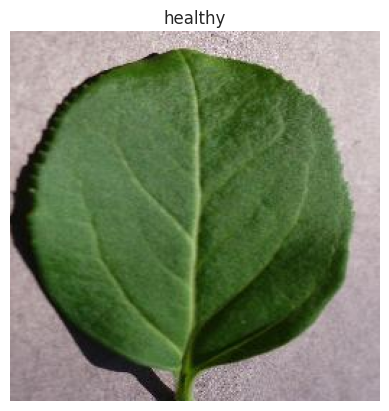

(20, 256, 256, 3)


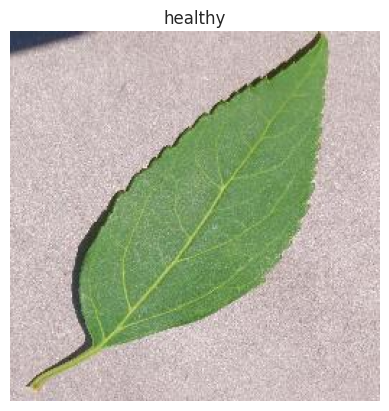

(20, 256, 256, 3)


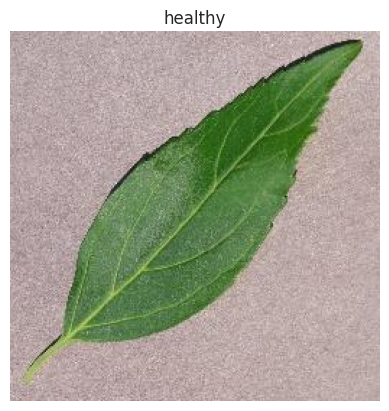

In [19]:
plot_augmented_image(test_set)

Save class indices

In [20]:
joblib.dump(value=train_set.class_indices ,
            filename=f"{file_path}/class_indices.pkl")

['outputs/v1/class_indices.pkl']

---

### Creating the Model

To be able to meet the business requirements of the client, a Conventional Neural Network (CNN) model will learn from the dominant features contained within the powdery mildew images of the cherry leaves.

Import Model ML packages

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model

In [22]:
EPOCHS = 15
OUTPUT_DIR = 'outputs/v1'

ML Model

In [23]:
def create_model():
    model = Sequential()
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=8, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Conv2D(filters=4, kernel_size=(3,3),input_shape=image_shape, activation='relu',))
    model.add(MaxPooling2D(pool_size=(2, 2)))


    model.add(Flatten())
    model.add(Dense(128, activation = 'relu'))

    model.add(Dropout(0.4))
    model.add(Dense(1, activation = 'sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

The Model summary

In [24]:
create_model().summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 8)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 8)       584       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 8)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 4)         292       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 4)        0

2023-02-12 11:45:10.836374: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-12 11:45:10.836412: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-12 11:45:10.836432: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (onursoyar-mildewdetecti-jmwd1pmev47): /proc/driver/nvidia/version does not exist
2023-02-12 11:45:10.836723: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Early stopping

In [25]:
early_stop = EarlyStopping(monitor='val_loss', patience=3)

Fit Model for Training

In [26]:
model = create_model()
model.fit(train_set,
          epochs=EPOCHS,
          steps_per_epoch = len(train_set.classes) // batch_size,
          validation_data = validation_set,
          callbacks=[early_stop],
          verbose=1)

Epoch 1/15
147/147 [==============================] - 49s 325ms/step - loss: 0.2167 - accuracy: 0.9101 - val_loss: 0.0652 - val_accuracy: 0.9786
Epoch 2/15
147/147 [==============================] - 58s 394ms/step - loss: 0.0645 - accuracy: 0.9771 - val_loss: 0.0250 - val_accuracy: 0.9929
Epoch 3/15
147/147 [==============================] - 60s 405ms/step - loss: 0.0571 - accuracy: 0.9808 - val_loss: 0.0244 - val_accuracy: 0.9952
Epoch 4/15
147/147 [==============================] - 48s 329ms/step - loss: 0.0407 - accuracy: 0.9870 - val_loss: 0.0296 - val_accuracy: 0.9881
Epoch 5/15
147/147 [==============================] - 61s 411ms/step - loss: 0.0244 - accuracy: 0.9918 - val_loss: 0.0102 - val_accuracy: 0.9976
Epoch 6/15
147/147 [==============================] - 57s 386ms/step - loss: 0.0310 - accuracy: 0.9891 - val_loss: 0.0220 - val_accuracy: 0.9881
Epoch 7/15
147/147 [==============================] - 59s 400ms/step - loss: 0.0247 - accuracy: 0.9918 - val_loss: 0.0198 - val_ac

Save Model

In [27]:
model.save(f'{OUTPUT_DIR}/mildew_detector_model.h5')

### Model Performance

Model learning curve

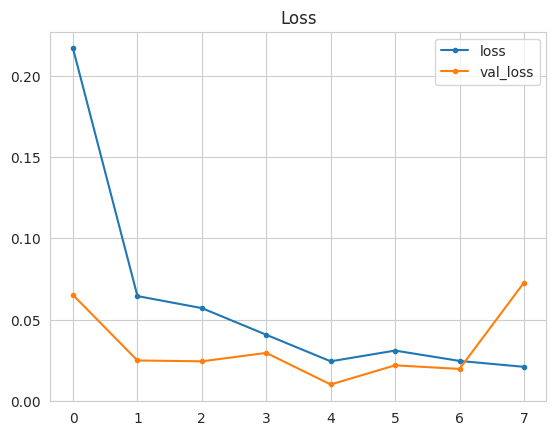

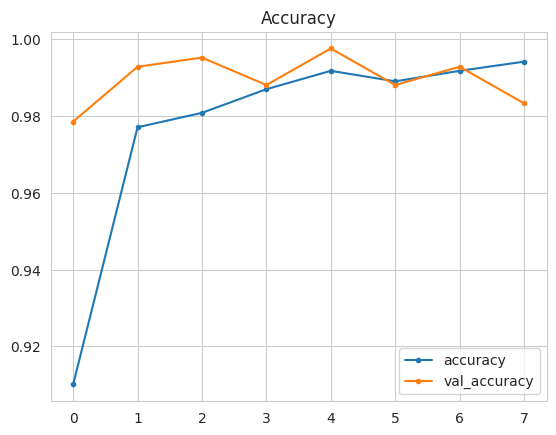

In [28]:
losses = pd.DataFrame(model.history.history)

sns.set_style("whitegrid")
losses[['loss','val_loss']].plot(style='.-')
plt.title("Loss")
plt.savefig(f'{file_path}/model_training_losses.png', bbox_inches='tight', dpi=150)
plt.show()

print("\n")
losses[['accuracy','val_accuracy']].plot(style='.-')
plt.title("Accuracy")
plt.savefig(f'{file_path}/model_training_acc.png', bbox_inches='tight', dpi=150)
plt.show()

#### Model Evaluation

Load saved model

In [29]:
from keras.models import load_model
model = load_model(f'{OUTPUT_DIR}/mildew_detector_model.h5')

Evaluate the model on the test set

In [30]:
evaluation = model.evaluate(test_set)


43/43 [==============================] - 3s 78ms/step - loss: 0.0650 - accuracy: 0.9882


Save evaluation pickle

In [31]:
joblib.dump(value=evaluation, filename=f'{OUTPUT_DIR}/evaluation.pkl')

['outputs/v1/evaluation.pkl']

Predict new Data

Image shape: (256, 256), Image mode: RGB


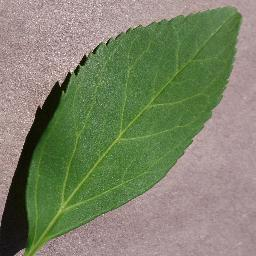

In [32]:
from tensorflow.keras.preprocessing import image

pointer = 66 
label = labels[0] # select Uninfected or Parasitized

pil_image = image.load_img(test_path + '/'+ label + '/'+ os.listdir(test_path+'/'+ label)[pointer],
                          target_size=image_shape, color_mode='rgb')
print(f'Image shape: {pil_image.size}, Image mode: {pil_image.mode}')
pil_image

Convert images to Array for the purpose of prediction

In [33]:
my_image = image.img_to_array(pil_image)
my_image = np.expand_dims(my_image, axis=0)/255
print(my_image.shape)

(1, 256, 256, 3)


Predict the class probabilities

In [34]:
prediction_probability = model.predict(my_image)[0,0]

target_map = {v: k for k, v in train_set.class_indices.items()}
predicted_class =  target_map[prediction_probability > 0.5]  

if predicted_class == target_map[0]: prediction_probability = 1 - prediction_probability

print(f'Prediction probability: {prediction_probability}')
print(f'Predicted class: {predicted_class}')

1/1 [==============================] - 0s 92ms/step
Prediction probability: 0.9999997850840998
Predicted class: healthy


---

## Push to Github

---

* git add .
* git commit -m "->message describing alterations to cells/code and purpose"
* git push